In [44]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import List 
import imageio # convert numpy arr to gif

In [45]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [46]:
physical_devices=tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Build Data Loading Functions

In [47]:
# import zipfile

# extract data.zip file

# with zipfile.ZipFile("data.zip","r") as zip_ref:
#     zip_ref.extractall("data")

In [48]:
def load_video(path:str)->List[float]:
    """
    Loads a video from a given path and returns a list of frames
    """
    cap = cv2.VideoCapture(path) 
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame=cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) # isolating the lip region
        # we can also use delib to extract the lip
    cap.release()

    mean= tf.math.reduce_mean(frames) # scale the data
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    frames=tf.cast((frames-mean),tf.float32)/std
    return frames

In [49]:
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [99]:
# Modify the vocab to include special tokens used by StringLookup layers
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab=["[UNK]"]+vocab

In [95]:
print(vocab)

['[UNK]', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [100]:
# https://keras.io/examples/audio/ctc_asr/#model

# lookup functions to convert and reconvert text to encoding
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),invert=True,mask_token=""
)
print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is : ['', '[UNK]', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =41)


In [101]:
char_to_num.get_vocabulary()

['',
 '[UNK]',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [102]:
print(num_to_char.get_vocabulary())

['', '[UNK]', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [103]:
char_to_num(['a','b','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4], dtype=int64)>

In [104]:
char_to_num(['n','s','t','e']) # tokenizing the data and returning the tokens

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([15, 20, 21,  6], dtype=int64)>

In [106]:
num_to_char([15, 20, 21,6]) # returns byte encoded value

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b's', b't', b'e'], dtype=object)>

In [83]:
# load alignments

def load_alignments(path:str)->List[int]:
    """
    Loads the alignments from a given path and returns a list of integers
    """
    with open(path,"r") as f:
        lines=f.readlines()
    tokens=[]
    for line in lines:
        line=line.split()
        # data preprocessing
        if(line[2]!='sil'): # sil - silence
            tokens=[*tokens,' ',line[2]]
    # print(tokens)
    # preprocessed alignments
    print((tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:])
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]



In [76]:
def load_data(path:str):
    """
    Loads the video and alignments from a given path and returns a list of frames and alignments
    """
    path=bytes.decode(path.numpy())
    file_name=path.split('\\')[-1].split('.')[0]
    video_path=os.path.join('data','data','s1',f"{file_name}.mpg")
    alignment_path=os.path.join('data','data','alignments','s1',f"{file_name}.align")
    # print(alignment_path)
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)

    return frames,alignments


In [77]:
test_path = "data\\data\\s1\\bbaf2n.mpg"

In [78]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'data\\data\\s1\\bbaf2n.mpg'

In [79]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [60]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.4991665 ],
          [1.4991665 ],
          [1.4616873 ],
          ...,
          [0.41227078],
          [0.41227078],
          [0.41227078]],
 
         [[1.4991665 ],
          [1.4991665 ],
          [1.4616873 ],
          ...,
          [0.41227078],
          [0.41227078],
          [0.41227078]],
 
         [[1.4616873 ],
          [1.4616873 ],
          [1.4991665 ],
          ...,
          [0.33731246],
          [0.33731246],
          [0.33731246]],
 
         ...,
 
         [[1.0494165 ],
          [1.0494165 ],
          [1.0119374 ],
          ...,
          [0.11243749],
          [0.11243749],
          [0.07495832]],
 
         [[1.0494165 ],
          [1.0494165 ],
          [1.0119374 ],
          ...,
          [0.11243749],
          [0.07495832],
          [0.07495832]],
 
         [[1.0494165 ],
          [1.0494165 ],
          [1.0119374 ],
          ...,
          [0.07495832],
    

In [85]:
frames,alignments= load_data(tf.convert_to_tensor(test_path))

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'f', ' ', 'two', ' ', 'now']
tf.Tensor(
[b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f' b' '
 b't' b'w' b'o' b' ' b'n' b'o' b'w'], shape=(21,), dtype=string)


In [86]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [63]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991665 ],
         [1.4991665 ],
         [1.4616873 ],
         ...,
         [0.41227078],
         [0.41227078],
         [0.41227078]],

        [[1.4991665 ],
         [1.4991665 ],
         [1.4616873 ],
         ...,
         [0.41227078],
         [0.41227078],
         [0.41227078]],

        [[1.4616873 ],
         [1.4616873 ],
         [1.4991665 ],
         ...,
         [0.33731246],
         [0.33731246],
         [0.33731246]],

        ...,

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.11243749],
         [0.11243749],
         [0.07495832]],

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.11243749],
         [0.07495832],
         [0.07495832]],

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

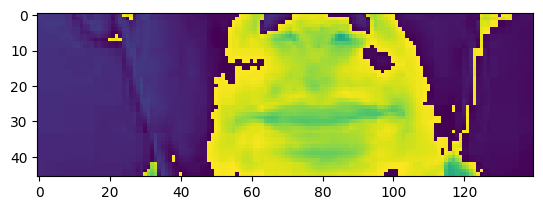

In [64]:
plt.imshow(frames[0])

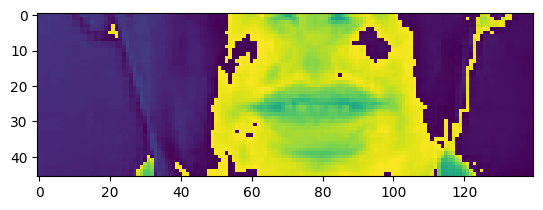

In [65]:
plt.imshow(frames[20])

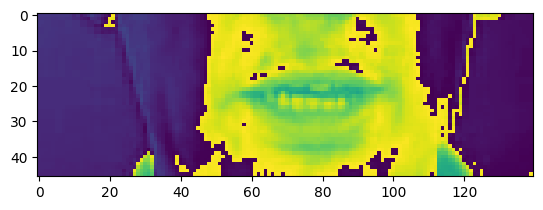

In [66]:
plt.imshow(frames[50])

In [67]:
len(frames)

75

In [87]:
print(alignments.numpy())
print(num_to_char(alignments.numpy()).numpy())
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


[ 2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23]
[b'a' b'h' b'm' b'9' b'a' b'k' b't' b'd' b'9' b'' b's' b'9' b'e' b'9' b's'
 b'v' b'n' b'9' b'm' b'n' b'v']
['a', 'h', 'm', '9', 'a', 'k', 't', 'd', '9', '', 's', '9', 'e', '9', 's', 'v', 'n', '9', 'm', 'n', 'v']


In [69]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'ahm9aktd9s9e9svn9mnv'>